SANET MODEL IMPLEMENTATION - CK+

IMPORTING LIBRARIES

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Activation, Multiply
from keras.callbacks import Callback
import matplotlib.pyplot as plt

SANET - LOADING DATA - KAROLINSKA

In [2]:
# Set the path to the folder containing images
data_path = "C:/Users/HP/Desktop/MSc Thesis/DATASETS/Karolinska Datasets"

# Define the emotion classes
emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy',  'Neutral', 'Sad', 'Surprise']

# Set the image size and batch size
image_size = (48, 48)
batch_size = 32

SANET - DATA PREPROCESSING - KAROLINSKA

In [3]:
def load_data():
    images = []
    labels = []
    for emotion_class in emotion_classes:
        class_path = os.path.join(data_path, emotion_class)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path).convert('L')  # Convert the images to grayscale
            image = image.resize(image_size)
            images.append(np.array(image))
            labels.append(emotion_classes.index(emotion_class))
    return np.array(images), np.array(labels)

images, labels = load_data()


# Split the data into training, validation, and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42) 

# Reshape the data for SANET (CNN) input
X_train = X_train.reshape(X_train.shape[0], image_size[0], image_size[1], 1)
X_val = X_val.reshape(X_val.shape[0], image_size[0], image_size[1], 1)
X_test = X_test.reshape(X_test.shape[0], image_size[0], image_size[1], 1)

# Normalize the pixel values between 0 and 1
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# One hot encoding
num_classes = len(emotion_classes)
y_train = np.eye(num_classes)[y_train]
y_val = np.eye(num_classes)[y_val]
y_test = np.eye(num_classes)[y_test]

SANET - IMPLEMENTING ATTENTION BLOCK - KAROLINSKA

In [6]:
from keras.layers import Input, Add, Activation, Multiply
from keras.models import Model

# Implement the attention block for SANET
def attention_block(input_tensor, kernel_size=7):
    # 1x1 conv
    x = Conv2D(1, (1, 1), padding='same')(input_tensor)
    
    # Blurring Pooling
    x = MaxPooling2D((kernel_size, kernel_size), strides=(1,1), padding='same')(x)
    
    # Activation
    x = Activation('sigmoid')(x)
    
    # Element-wise multiplication
    x = Multiply()([input_tensor, x])
    return x

SANET MODEL TRAINING  - KAROLINSKA

In [ ]:
import psutil

# Function to convert bytes to megabytes
def bytes_to_megabytes(bytes):
    return bytes / (1024.0 ** 2)

# Initial RAM usage
initial_memory = psutil.virtual_memory().used
print(f"Initial RAM used: {bytes_to_megabytes(initial_memory):.2f} MB")

# Implement the SANET structure
def create_SANET_model():
    input_layer = Input(shape=(image_size[0], image_size[1], 1))

    x = Conv2D(64, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Apply attention mechanism twice
    x = attention_block(x)
    x = attention_block(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# Training the model
model = create_SANET_model()

# RAM usage after model creation
after_creation_memory = psutil.virtual_memory().used
print(f"RAM used after model creation: {bytes_to_megabytes(after_creation_memory):.2f} MB")
print(f"Approximate RAM used during model creation: {bytes_to_megabytes(after_creation_memory - initial_memory):.2f} MB")


from keras.callbacks import Callback

# Define a custom callback to evaluate the model on the test set
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_acc = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        self.test_acc.append(acc)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

test_callback = TestCallback((X_test, y_test))
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[test_callback], verbose=1)

# RAM usage after training
after_training_memory = psutil.virtual_memory().used
print(f"RAM used after model training: {bytes_to_megabytes(after_training_memory):.2f} MB")
print(f"Approximate RAM used during training: {bytes_to_megabytes(after_training_memory - after_creation_memory):.2f} MB")

SANET - ACCURACY vs EPOCH PLOT - KAROLINSKA

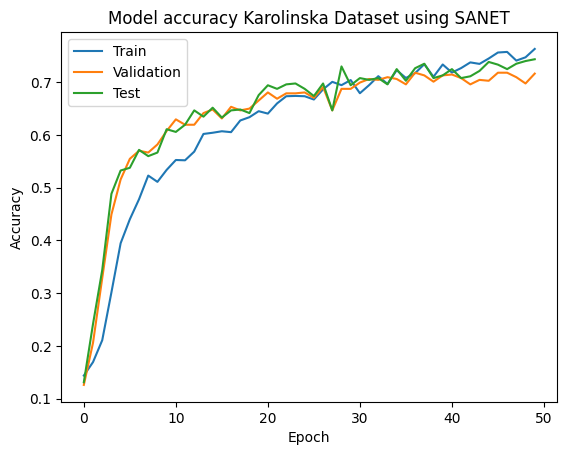

In [9]:
# Plot Accuracy vs Epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(test_callback.test_acc)  # Plot test accuracy
plt.title('Model accuracy Karolinska Dataset using SANET')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
plt.show()

SANET - ERROR RATE PLOT - KAROLINSKA

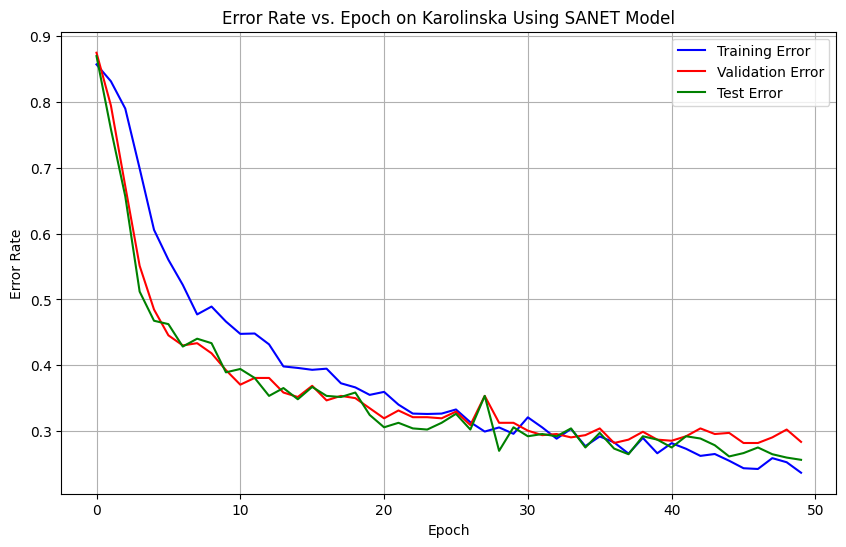

In [10]:
import matplotlib.pyplot as plt

# Calculate error rates
train_error = [1 - acc for acc in history.history['accuracy']]
val_error = [1 - acc for acc in history.history['val_accuracy']]
test_error = [1 - acc for acc in test_callback.test_acc]

# Plotting the error rate
plt.figure(figsize=(10, 6))
plt.plot(train_error, label='Training Error', color='blue')
plt.plot(val_error, label='Validation Error', color='red')
plt.plot(test_error, label='Test Error', color='green')
plt.title('Error Rate vs. Epoch on Karolinska Using SANET Model')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


SANET - CLASSIFICATION REPORT - KAROLINSKA

In [11]:
from sklearn.metrics import classification_report

# Printing the classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred_classes, target_names=emotion_classes)
print(report)

19/19 [==============================] - 1s 39ms/step
              precision    recall  f1-score   support

       Angry       0.71      0.89      0.79        90
     Disgust       0.88      0.84      0.86        86
        Fear       0.62      0.56      0.59        90
       Happy       0.92      0.99      0.95        81
     Neutral       0.69      0.72      0.71        80
         Sad       0.61      0.47      0.53        77
    Surprise       0.73      0.73      0.73        84

    accuracy                           0.74       588
   macro avg       0.74      0.74      0.74       588
weighted avg       0.74      0.74      0.74       588



SANET - CONFUSION MATRIX - KAROLINSKA

19/19 [==============================] - 1s 36ms/step


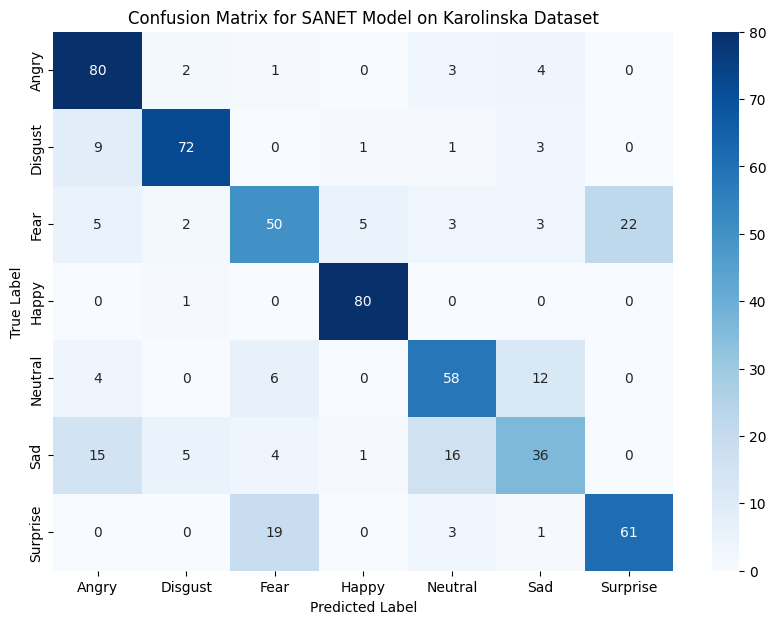

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict classes on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SANET Model on Karolinska Dataset')
plt.show()

SANET - ROC CURVE PLOT - KAROLINSKA

19/19 [==============================] - 1s 43ms/step


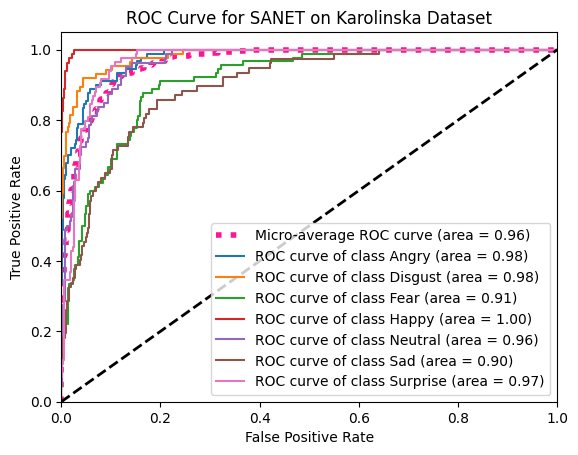

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute and plot the ROC curve
def plot_sanet_roc_curve(y_true, y_pred_probabilities, classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], 
             label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for SANET on Karolinska Dataset')
    plt.legend(loc="lower right")
    plt.show()

# Assuming model is the SANET model
y_pred_probabilities_sanet = model.predict(X_test)

# Plot the ROC curve for SANET
plot_sanet_roc_curve(y_test, y_pred_probabilities_sanet, emotion_classes)